## Questions
1. How many free texts are associated with the patients with inputs of potential blood transfusion reaction products? Those later identified without transfusion reaction could serve as negative label 
2. What are potential key words to look for transfusion reaction? Is there a feasible rule-based apporoach? In what kinds of notes (physicians? nurses?)
3. How does the notes compare to Kat's methods? 

In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from google.cloud import bigquery
pd.set_option('display.max_rows', 100)    # Show all rows



load_dotenv()
query_path = os.environ.get('BASE_QUERY_PATH')
client = bigquery.Client(os.environ.get('BIGQUERY_PROJECT_NAME'))

In [2]:
# Look at example free-text notes from noteevents 
with open(f"{query_path}/free_text_examples.sql", 'r') as file:
    query_fte = file.read()

results_fte = client.query(query_fte).to_dataframe()
print(results_fte)

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   ROW_ID  SUBJECT_ID  HADM_ID   CHARTDATE           CHARTTIME  \
0  653713       83272   118308  2108-12-06 2108-12-06 11:23:00   
1  548771       46960   153896  2194-11-06 2194-11-06 17:30:00   
2  931289       22419     <NA>  2156-12-20 2156-12-20 00:00:00   
3  670683       46836   199740  2165-03-28 2165-03-28 12:38:00   
4  670707       57310   193828  2162-05-06 2162-05-06 12:52:00   
5  601062       64825   177337  2108-10-12 2108-10-12 12:16:00   
6   59677       23224   174680  2147-11-18                 NaT   
7  305237       42028     <NA>  2129-08-05                 NaT   
8  308657       12375   197471  2107-07-24                 NaT   
9   47479       41890   151796  2142-06-13                 NaT   

            STORETIME           CATEGORY DESCRIPTION   CGID  ISERROR  \
0 2108-12-06 11:24:04         Physician          CVI  15626     <NA>   
1 2194-11-06 17:31:09         Physician          CVI  15626     <NA>   
2                 NaT          Radiology         RVG   <N

In [9]:
# Show one text records 
# print(results_fte.loc[1, "TEXT"]) # hide for HIPAA 

In [3]:
# Look at transfusion input from Kat and Quinn
# as per our esteemed clinician's advice, we will use the following blood products:
chosen_blood_products_mv = (225168, 225170, 225171, 227070, 227071, 227072, 220970, 227532, 226367, 226368, 226369, 226371)
chosen_blood_products_cv = (30179, 30001, 30004, 30005, 30180)
# https://mimic.mit.edu/docs/iii/tables/inputevents_mv/ 

with open(f"{query_path}/all_blood_inputs.sql", 'r') as file:
    query = file.read()

completed_results = client.query(query).to_dataframe()
completed_results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,subject_id,hadm_id,icustay_id,starttime,endtime,duration_minutes,itemid,label,amount,amountuom,totalamount,totalamountuom,statusdescription,cancelreason,orderid,linkorderid
0,87608,152229,252764,2181-01-16 01:09:00,2181-01-16 01:10:00,1,227072,PACU FFP Intake,290.000000,ml,290.0,ml,FinishedRunning,0,393993,393993
1,93636,190170,277909,2192-08-06 12:00:00,2192-08-06 12:01:00,1,226367,OR FFP Intake,0.000000,ml,NaN,ml,FinishedRunning,0,8359224,8359224
2,76265,158504,291993,2187-09-25 13:20:00,2187-09-25 13:21:00,1,226367,OR FFP Intake,276.000000,ml,276.0,ml,FinishedRunning,0,2590864,2590864
3,59864,197793,288369,2173-05-16 12:30:00,2173-05-16 12:31:00,1,226367,OR FFP Intake,315.000000,ml,315.0,ml,FinishedRunning,0,6560152,6560152
4,66745,192825,298534,2145-11-15 03:00:00,2145-11-15 03:01:00,1,226367,OR FFP Intake,1964.000000,ml,1964.0,ml,FinishedRunning,0,6899860,6899860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42653,55272,156180,230768,2159-12-17 14:12:00,2159-12-17 14:57:00,45,225168,Packed Red Blood Cells,374.999985,ml,375.0,ml,Rewritten,2,8718915,8718915
42654,29035,119860,235102,2155-03-12 03:45:00,2155-03-12 04:22:00,37,225168,Packed Red Blood Cells,630.999998,ml,631.0,ml,Rewritten,2,3946645,3946645
42655,53626,155583,266835,2120-02-09 10:39:00,2120-02-09 11:01:00,22,225168,Packed Red Blood Cells,374.999988,ml,375.0,ml,Rewritten,2,6577686,6577686
42656,82322,140140,237924,2189-06-30 10:50:00,2189-06-30 11:11:00,21,225168,Packed Red Blood Cells,349.999986,ml,350.0,ml,Rewritten,2,138817,138817


In [33]:
# Note entries with matched subject_id from all_blood_inputs, documented on the same or next day of input 
# with open(f"{query_path}/blood_notes.sql", 'r') as file: # Caution: run time = 11 min, 479399 rows
with open(f"{query_path}/blood_notes_1d.sql", 'r') as file: # Caution: run time = 8 min, 309714 rows   
    query_blood_notes = file.read()

blood_notes = client.query(query_blood_notes).to_dataframe()
blood_notes

/home/ch123ck/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,264534,7709,<NA>,2171-04-25,NaT,NaT,ECG,Report,<NA>,<NA>,ECG interpreted by ordering physician.\n[**Nam...
1,341428,27172,140642,2109-08-07,2109-08-07 12:56:00,2109-08-07 13:19:46,Nutrition,Clinical Nutrition Note,14511,<NA>,Subjective\n Pt intubated\n Objective\n ...
2,438916,55036,186141,2131-01-03,2131-01-03 12:43:00,2131-01-03 12:43:48,Social Work,Social Work Progress Note,18371,<NA>,Social Work:\n Rec\nd POE referral on this 6...
3,234745,57161,160943,2142-02-10,NaT,NaT,ECG,Report,<NA>,<NA>,Sinus bradycardia with sinus arrhythmia. Cris...
4,415584,42367,139932,2147-10-19,2147-10-19 04:28:00,2147-10-19 04:28:24,Respiratory,Generic Note,17443,<NA>,TITLE:\n Respiratory: Rec\nd pt on 50% t/c a...
...,...,...,...,...,...,...,...,...,...,...,...
309709,1123210,22942,<NA>,2196-03-18,2196-03-18 14:27:00,NaT,Radiology,R UNILAT LOWER EXT VEINS RIGHT,<NA>,<NA>,[**2196-3-18**] 2:27 PM\n UNILAT LOWER EXT VEI...
309710,1069334,90873,165474,2116-03-03,2116-03-03 09:49:00,NaT,Radiology,BY SAME PHYSICIAN,<NA>,<NA>,"[**Last Name (LF) **],[**First Name3 (LF) 1074..."
309711,1156283,96259,<NA>,2187-11-09,2187-11-09 21:58:00,NaT,Radiology,LIVER OR GALLBLADDER US (SINGLE ORGAN),<NA>,<NA>,"[**Last Name (LF) **],[**First Name3 (LF) **] ..."
309712,492424,81154,102807,2184-10-16,2184-10-16 05:58:00,2184-10-16 05:58:56,Nursing,Nursing Progress Note,15526,<NA>,"68 y/o M pmh esophageal CA, recent admission w..."


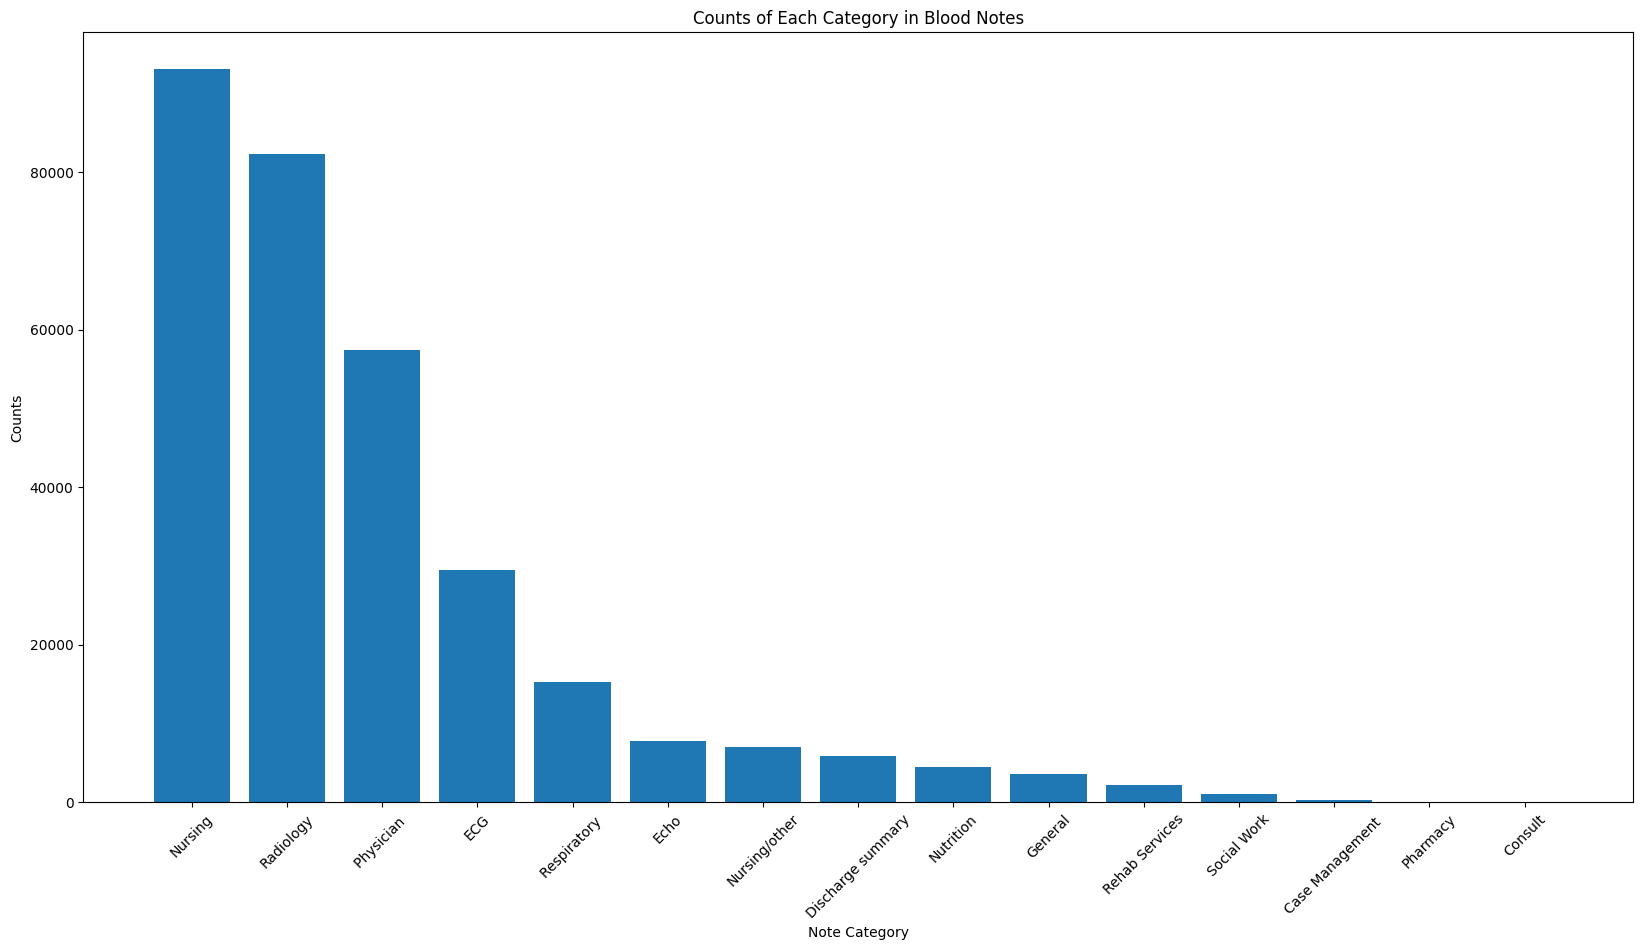

In [40]:
import matplotlib.pyplot as plt

# Count note category
note_type_count = blood_notes["CATEGORY"].value_counts()
plt.figure(figsize=(20, 10))
plt.bar(note_type_count.index, note_type_count.values)
plt.xlabel("Note Category")
plt.ylabel("Counts")
plt.title("Counts of Each Category in Blood Notes")
plt.xticks(rotation=45)
plt.show()

In [110]:
# Use regex to find 'transfusion reaction'
TR_idx = blood_notes['TEXT'].str.contains('transfusion reaction', regex=True, case=False)
TR_notes = blood_notes[TR_idx]
TR_notes

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
1054,498952,52453,155332,2172-10-22,2172-10-22 06:43:00,2172-10-22 06:44:38,Physician,Physician Resident Progress Note,19854,<NA>,Chief Complaint: Throat swelling\n 24 Hour E...
1321,526128,71698,115429,2109-02-02,2109-02-02 23:49:00,2109-02-02 23:49:02,Nursing,Nursing Transfer Note,16866,<NA>,SICU\n HPI:\n 72 yo left handed male w/ P...
2071,441818,98220,173136,2173-03-04,2173-03-04 08:27:00,2173-03-04 09:23:45,Nursing,Nursing Transfer Note,19169,<NA>,SICU\n HPI:\n HPI: 69 with h/o gastric PUD...
3723,704852,88243,176719,2161-11-14,2161-11-14 01:08:00,2161-11-14 01:08:42,Physician,Physician Resident Admission Note,15993,<NA>,Chief Complaint: Back Pain\n HPI:\n This ...
3938,736790,52228,155354,2172-04-03,2172-04-03 06:21:00,2172-04-03 06:43:21,Nursing,Nursing Progress Note,18076,<NA>,"Ms. [**Known lastname 2439**] is 43F with ""sar..."
...,...,...,...,...,...,...,...,...,...,...,...
308330,558170,45566,114477,2194-03-07,2194-03-07 02:13:00,2194-03-07 06:09:09,Nursing,Nursing Progress Note,18469,<NA>,78 yo Cantonese speaking male with new diagnos...
308512,367639,30887,134444,2147-02-12,2147-02-12 08:57:00,2147-02-12 17:29:45,Nursing,Nursing Progress Note,21116,<NA>,"55 y/o m with Cirrhosis, s/p therapeutic parac..."
308639,440911,98220,173136,2173-02-27,2173-02-27 03:06:00,2173-02-27 03:06:19,Physician,Intensivist Note,19882,<NA>,SICU\n HPI:\n 69 with h/o gastric PUD s/p ...
308984,558225,45566,114477,2194-03-07,2194-03-07 10:03:00,2194-03-07 10:06:45,Physician,Physician Attending Progress Note,21102,<NA>,Chief Complaint:\n I saw and examined the pa...


In [74]:
# Who document transfusion reaction? 
TR_note_counts = TR_notes["CATEGORY"].value_counts()
TR_note_counts

CATEGORY
Physician            282
Nursing              271
Discharge summary     31
Radiology             23
Nursing/other         10
General                3
Rehab Services         1
Name: count, dtype: int64

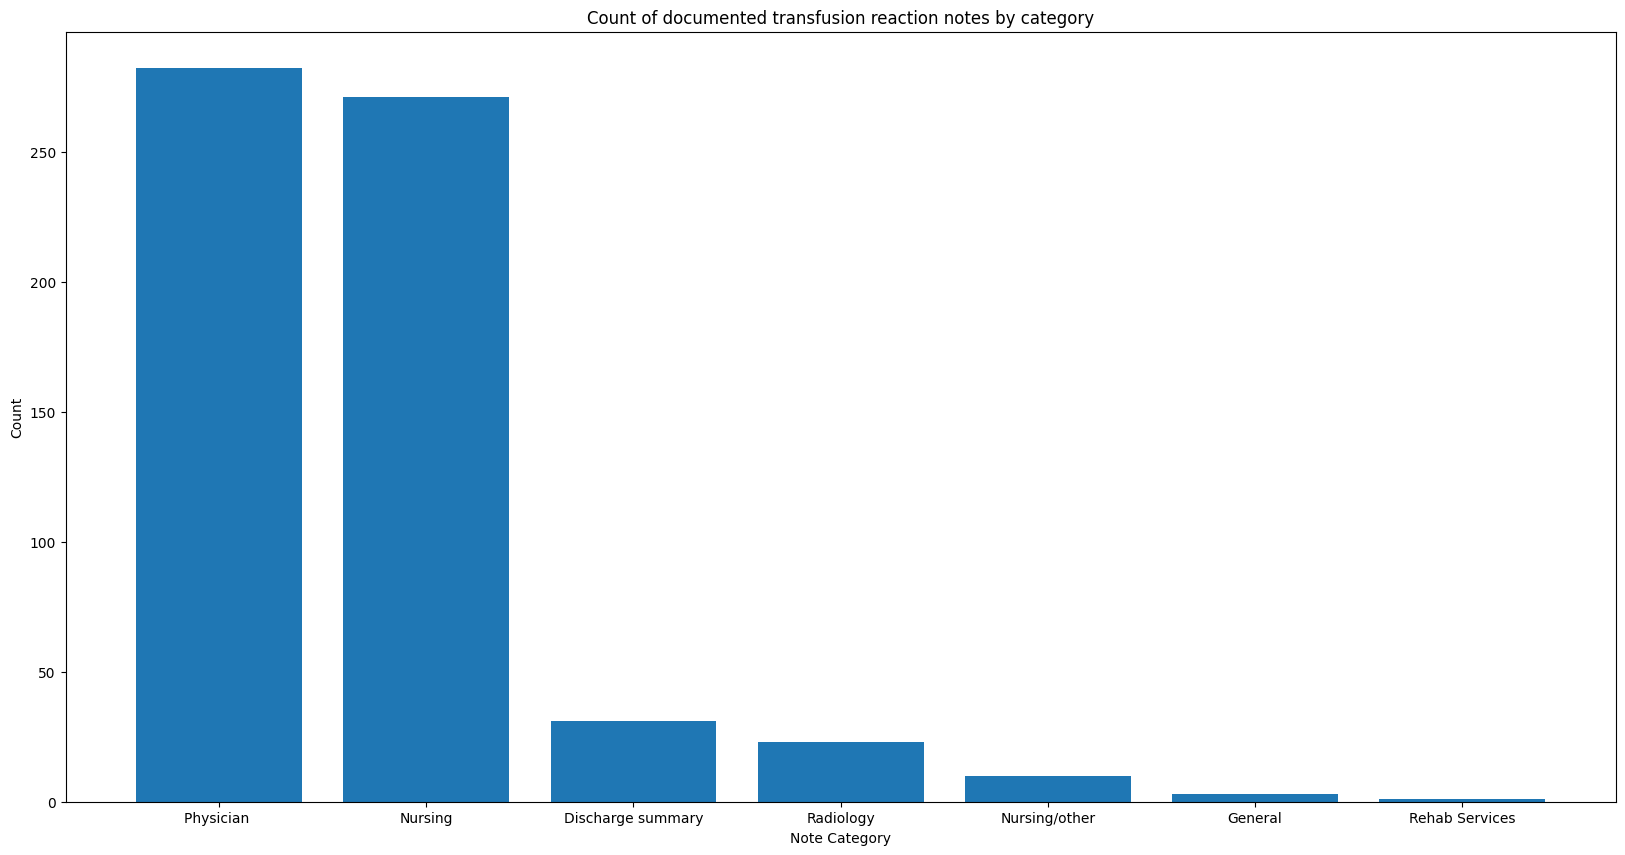

In [76]:
plt.figure(figsize=(20,10))
plt.bar(TR_note_counts.index, TR_note_counts.values)
plt.xlabel("Note Category")
plt.ylabel("Count")
plt.title("Count of documented transfusion reaction notes by category")
plt.show()

In [99]:
# Count the percentage of transfusion reaction in blood notes
TR_note_df = pd.DataFrame({'Category': TR_note_counts.index, 'count_TR': TR_note_counts.values})
note_type_df = pd.DataFrame({'Category': note_type_count.index, 'count_blood': note_type_count.values})
TR_note_type_df = TR_note_df.merge(note_type_df, on='Category', how='left')
TR_note_type_df['Percentage'] = TR_note_type_df['count_TR']/TR_note_type_df['count_blood']
TR_note_type_df

,Category,count_TR,count_blood,Percentage
0,Physician,282,57423,0.004911
1,Nursing,271,93109,0.002911
2,Discharge summary,31,5805,0.005340
3,Radiology,23,82297,0.000279
4,Nursing/other,10,7068,0.001415
5,General,3,3577,0.000839
6,Rehab Services,1,2183,0.000458


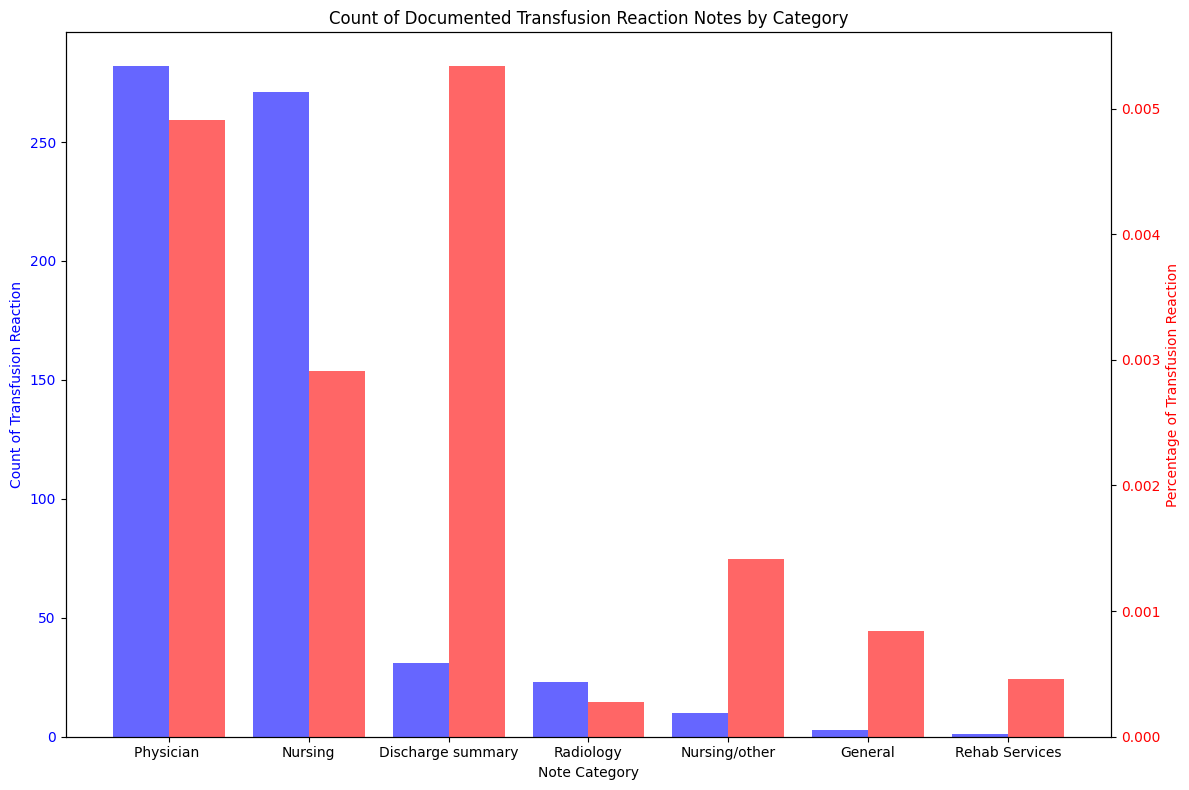

In [109]:
fig, ax1 = plt.subplots(figsize=(12, 8))

# Set the width of the bars
bar_width = 0.4

# Set the x locations for the bars
x1 = np.arange(len(TR_note_counts))  # X positions for the count bars
x2 = x1 + bar_width  # X positions for the percentage bars

# First bar graph (Count)
ax1.bar(x1, TR_note_counts.values, width=bar_width, color='b', alpha=0.6, label='Count')
ax1.set_xlabel("Note Category")
ax1.set_ylabel("Count of Transfusion Reaction", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Count of Documented Transfusion Reaction Notes by Category")
ax1.set_xticks(x1 + bar_width / 2)  # Centering the x-ticks between the two sets of bars
ax1.set_xticklabels(TR_note_counts.index)

# Create a second y-axis for the second bar graph (Percentage)
ax2 = ax1.twinx()
ax2.bar(x2, TR_note_type_df['Percentage'], width=bar_width, color='r', alpha=0.6, label='Percentage')
ax2.set_ylabel("Percentage of Transfusion Reaction", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Show the plot
plt.tight_layout()
plt.show()

In [114]:
# Look at Examples of Discharge Summary 
# Note: Be aware of HIPAA guideline 
print('Nursing-------------------------------------------------------')
print(TR_notes[TR_notes['CATEGORY']=='Nursing'].iloc[0,10])
print('Physician------------------------------------------------------')
print(TR_notes[TR_notes['CATEGORY']=='Physician '].iloc[0,10])
print('Discharge summary------------------------------------------------------')
print(TR_notes[TR_notes['CATEGORY']=='Discharge summary'].iloc[0,10])

Nursing-------------------------------------------------------
SICU
   HPI:
    72 yo left handed male w/ PMHx sig for CAD s/p MI, CABG, CHF
   w/ EF 15% who presents as transfer from OSH for SDH.  The history
   is obtained through wife as patient appears fatigued and in
   slight resp distress.  His wife found him outside three days ago
   crawling to the house.  He said that he had fallen.  She then
   noticed 1-2 days ago that he had trouble walking.  He stayed in
   bed almost all of yesterday.  Today she notice that his R arm and
   leg were not working very well.  He also saying things that did
   not make sense at times like he was "going back to [**State 1198**]" when
   there were no plans to do so.  He could only walk [**1-25**] steps with
   a walker yesterday.  He was brought to an OSH today where head CT
   showed a large 3 cm L SDH with 1 cm midline shift.
   The patient was given Vitamin K, FFP, and platelets prior to
   transfer to [**Hospital1 19**].  Upon arrival he 